# Natural Language Processing with Deep Learning

__This is exactly the same notebook as in `../week10_textconv/.`__

__Feel free submit the seminar notebook, just make sure you read the assignments at the end.__

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
135352,70265282,Staff Nurse RGN Nights Swindon **** p/h Elderl...,SYK Recruitment Specialists are looking for an...,Swindon,Swindon,full_time,NaN,SYK Recruitment,Healthcare & Nursing Jobs,12.20 - 12.50/Hour,23712,staffnurse.com,10.073779
244006,72693415,Rental Income Officer,Rental income officer required for immediate s...,Dorking,Dorking,NaN,contract,Essential Employment Ltd,Other/General Jobs,12-14.87 per hr,25795,jobsite.co.uk,10.157975
208888,72160840,Exchange Connectivity Engineer ECN IT Consul...,"Exchange Connectivity Engineer job, ECN Specia...",London,London,NaN,permanent,Square One Resources,IT Jobs,60000.00 - 70000.00 GBP Annual,65000,jobserve.com,11.082158


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [6]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" fields
all_words = []
for title in data["Title"]:
    token_counts.update(title.split())
for descr in data["FullDescription"]:
    token_counts.update(descr.split())

In [7]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5,0,'Counts')

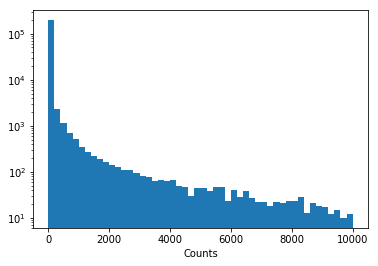

In [8]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, cnt in token_counts.items() if cnt >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [11]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [12]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [13]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [14]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [15]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [17]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [18]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[ 497,   57, 2157, 1093],
        [2358,    6,    1,    1],
        [ 497,   57, 6098,  322]]),
 'FullDescription': array([[  142,   497,    57,  2157,  1093,  3181,  2409,  1385,    86,
          1166],
        [33313,   332,   558,   559,  5782,    73,   142,  6261,  1166,
           360],
        [  497,    57,  6098,   322,    86, 12431,   906, 10978,     9,
           320]]),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([10.959558, 10.505095, 11.512936], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [19]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [20]:
class Optional(nn.Module):
    def __init__(self, module, use_module):
        super().__init__()
        self.use_module = use_module
        if self.use_module:
            self.internal_module = module
    
    def forward(self, x):
        if self.use_module:
            return self.internal_module(x)
        return x

In [21]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, use_bn=True):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.bn = Optional(nn.BatchNorm1d(out_size), use_module=use_bn)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.bn(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        
        return h

In [22]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [54]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class JobDescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), in_size=64, out_size=64, use_batchnorm=True):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super().__init__()
        self.emb = nn.Embedding(n_tokens, in_size, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(in_size, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()      
        self.dense = nn.Linear(out_size, out_size)
        self.bn = Optional(nn.BatchNorm1d(out_size), use_module=use_batchnorm)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.bn(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        
        return h
    
class JobDescriptionEncoder_cnn_parallel(nn.Module):
    def __init__(self, n_tokens=len(tokens), in_size=64, out_size=64, use_batchnorm=True):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super().__init__()
        self.emb = nn.Embedding(n_tokens, in_size, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(in_size, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_size, 32, kernel_size=3, padding=1)
        self.global_pool = GlobalMaxPooling()      
        self.dense = nn.Linear(96, out_size)
        self.bn1 = Optional(nn.BatchNorm1d(64), use_module=use_batchnorm)
        self.bn2 = Optional(nn.BatchNorm1d(32), use_module=use_batchnorm)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h1 = self.conv1(h)
        h1 = self.bn1(h1)
        h2 = self.conv2(h)
        h2 = self.bn2(h2)
        h = torch.cat([h1, h2], dim=1)
        h = self.global_pool(h)
        h = F.relu(h)
        h = self.dense(h)
        
        return h
    
class JobDescriptionEncoder_cnn_parallel2(nn.Module):
    def __init__(self, n_tokens=len(tokens), in_size=64, out_size=64, use_batchnorm=True):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super().__init__()
        self.emb = nn.Embedding(n_tokens, in_size, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(in_size, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_size, 32, kernel_size=2, padding=1)
        self.global_pool = GlobalMaxPooling()      
        self.dense = nn.Linear(96, out_size)
        self.bn1 = Optional(nn.BatchNorm1d(64), use_module=use_batchnorm)
        self.bn2 = Optional(nn.BatchNorm1d(32), use_module=use_batchnorm)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h1 = self.conv1(h)
        h1 = self.bn1(h1)
        h2 = self.conv2(h)
        h2 = self.bn2(h2)
        h1 = self.global_pool(h1)
        h2 = self.global_pool(h2)
        h = torch.cat([h1, h2], dim=1)
        h = F.relu(h)
        h = self.dense(h)
        
        return h
    
class JobDescriptionEncoder_cnn_parallel4(nn.Module):
    def __init__(self, n_tokens=len(tokens), in_size=64, out_size=64, use_batchnorm=True):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super().__init__()
        self.emb = nn.Embedding(n_tokens, in_size, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(in_size, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_size, 32, kernel_size=2, padding=1)
        self.conv3 = nn.Conv1d(in_size, 64, kernel_size=4, padding=1)
        self.conv4 = nn.Conv1d(in_size, 64, kernel_size=5, padding=1)
        self.global_pool = GlobalMaxPooling()      
        self.dense1 = nn.Linear(224, 256)
        self.dense2 = nn.Linear(256, out_size)
        self.bn1 = Optional(nn.BatchNorm1d(64), use_module=use_batchnorm)
        self.bn2 = Optional(nn.BatchNorm1d(32), use_module=use_batchnorm)
        self.bn3 = Optional(nn.BatchNorm1d(64), use_module=use_batchnorm)
        self.bn4 = Optional(nn.BatchNorm1d(64), use_module=use_batchnorm)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h1 = self.conv1(h)
        h1 = self.bn1(h1)
        h1 = self.global_pool(h1)
        h2 = self.conv2(h)
        h2 = self.bn2(h2)
        h2 = self.global_pool(h2)
        h3 = self.conv3(h)
        h3 = self.bn3(h3)
        h3 = self.global_pool(h3)
        h4 = self.conv4(h)
        h4 = self.bn4(h4)
        h4 = self.global_pool(h4)
        h = torch.cat([h1, h2, h3, h4], dim=1)
        h = self.dense1(h)
        h = F.relu(h)
        h = self.dense2(h)
        
        return h

In [24]:
desc_encoder = JobDescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [25]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, 
                 n_tokens=len(tokens), 
                 n_cat_features=len(categorical_vectorizer.vocabulary_),
                 title_encoder=TitleEncoder(out_size=64),
                 description_encoder=JobDescriptionEncoder(out_size=64),
                 out_size=64,
                 dropout_p=0.5,
                 use_bn=True,
                 use_dropout=True):
        super(self.__class__, self).__init__()
        
        self.title_encoder = title_encoder
        self.desc_encoder = description_encoder
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 512),
            Optional(nn.BatchNorm1d(512), use_bn),
            nn.ReLU(inplace=True),
            Optional(nn.Dropout(dropout_p), use_dropout),
            nn.Linear(512, 256),
            Optional(nn.BatchNorm1d(256), use_bn),
            nn.ReLU(inplace=True),
            Optional(nn.Dropout(dropout_p), use_dropout),
            nn.Linear(256, out_size)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Sequential(
            nn.Linear(3 * out_size, 128),
            Optional(nn.BatchNorm1d(128), use_bn),
            nn.ReLU(inplace=True),
            Optional(nn.Dropout(dropout_p), use_dropout),
            nn.Linear(128, 64),
            Optional(nn.BatchNorm1d(64), use_bn),
            nn.ReLU(inplace=True),
            Optional(nn.Dropout(dropout_p), use_dropout),
            nn.Linear(64, 32),
            Optional(nn.BatchNorm1d(32), use_bn),
            nn.ReLU(inplace=True),
            Optional(nn.Dropout(dropout_p), use_dropout),
            nn.Linear(32, 16),
            Optional(nn.BatchNorm1d(16), use_bn),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        res = self.output(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return res[:, 0]

In [26]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [27]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [28]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [29]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [30]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [31]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

### Baseline model

In [43]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.item()
        train_mae += compute_mae(reference, prediction).item()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        with torch.no_grad():
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.item()
            val_mae += compute_mae(reference, prediction).item()
            val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:



	Loss:	0.43878
	MAE:	6173.89400



Validation:


C:\ProgramData\Anaconda3\envs\torchEnv\lib\site-packages\ipykernel_launcher.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\envs\torchEnv\lib\site-packages\ipykernel_launcher.py:35: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\envs\torchEnv\lib\site-packages\ipykernel_launcher.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\envs\torchEnv\lib\site-packages\ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



	Loss:	0.36391
	MAE:	5254.87166



Training:



	Loss:	0.33165
	MAE:	5378.60417



Validation:



	Loss:	0.31257
	MAE:	5663.96165



Training:



	Loss:	0.27231
	MAE:	5001.05822



Validation:



	Loss:	0.26563
	MAE:	4903.36393



Training:



	Loss:	0.25875
	MAE:	4633.67788



Validation:



	Loss:	0.24414
	MAE:	4561.31275



Training:



	Loss:	0.23484
	MAE:	4615.45317



Validation:



	Loss:	0.22941
	MAE:	4439.25056



Training:



	Loss:	0.22152
	MAE:	4407.20931



Validation:



	Loss:	0.21174
	MAE:	4231.40809



Training:



	Loss:	0.20768
	MAE:	4284.18083



Validation:



	Loss:	0.20335
	MAE:	4030.88721



Training:



	Loss:	0.21198
	MAE:	4341.12789



Validation:



	Loss:	0.25521
	MAE:	5630.01772



Training:



	Loss:	0.20426
	MAE:	4331.60396



Validation:



	Loss:	0.19883
	MAE:	3923.49298



Training:



	Loss:	0.18920
	MAE:	4116.88667



Validation:



	Loss:	0.19085
	MAE:	3835.09813



Training:



	Loss:	0.18122
	MAE:	3981.12672



Validation:



	Loss:	0.24278
	MAE:	4252.21031



Training:



	Loss:	0.19097
	MAE:	4106.16313



Validation:



	Loss:	0.18178
	MAE:	4347.55853



Training:



	Loss:	0.18051
	MAE:	3912.34475



Validation:



	Loss:	0.15666
	MAE:	3614.07630



Training:



	Loss:	0.15453
	MAE:	3773.24861



Validation:



	Loss:	0.14858
	MAE:	3604.45920



Training:



	Loss:	0.16378
	MAE:	3897.92801



Validation:



	Loss:	0.15007
	MAE:	3524.85505



Training:



	Loss:	0.15393
	MAE:	3737.44572



Validation:



	Loss:	0.16968
	MAE:	3633.67082



Training:



	Loss:	0.14655
	MAE:	3718.97576



Validation:



	Loss:	0.13932
	MAE:	3476.51428



Training:



	Loss:	0.16422
	MAE:	3833.89201



Validation:



	Loss:	0.13558
	MAE:	3476.32593



Training:



	Loss:	0.15574
	MAE:	3800.46244



Validation:



	Loss:	0.15849
	MAE:	3555.88876



Training:



	Loss:	0.14905
	MAE:	3770.26132



Validation:



	Loss:	0.13792
	MAE:	3380.37262



Training:



	Loss:	0.13940
	MAE:	3606.86853



Validation:



	Loss:	0.13377
	MAE:	3588.50541



Training:



	Loss:	0.14528
	MAE:	3595.19172



Validation:



	Loss:	0.13248
	MAE:	3307.35261



Training:



	Loss:	0.15420
	MAE:	3695.32210



Validation:



	Loss:	0.15568
	MAE:	4081.75725



Training:



	Loss:	0.13022
	MAE:	3419.28461



Validation:



	Loss:	0.16980
	MAE:	4395.86526



Training:



	Loss:	0.14857
	MAE:	3658.97760



Validation:



	Loss:	0.13878
	MAE:	3777.16140



Training:



	Loss:	0.13709
	MAE:	3526.98077



Validation:



	Loss:	0.17570
	MAE:	4540.36087



Training:



	Loss:	0.12634
	MAE:	3364.27297



Validation:



	Loss:	0.11846
	MAE:	3243.18840



Training:



	Loss:	0.15209
	MAE:	3835.83891



Validation:



	Loss:	0.14083
	MAE:	3399.75191



Training:



	Loss:	0.13055
	MAE:	3484.44656



Validation:



	Loss:	0.11715
	MAE:	3287.44316



Training:



	Loss:	0.13131
	MAE:	3388.98913



Validation:



	Loss:	0.11971
	MAE:	3193.41837



Training:



	Loss:	0.13666
	MAE:	3574.20315



Validation:



	Loss:	0.17208
	MAE:	4491.00609



Training:



	Loss:	0.12890
	MAE:	3413.06887



Validation:



	Loss:	0.15323
	MAE:	4180.79035



Training:



	Loss:	0.12307
	MAE:	3308.76865



Validation:



	Loss:	0.16321
	MAE:	3633.62944



Training:



	Loss:	0.13259
	MAE:	3512.28786



Validation:



	Loss:	0.11452
	MAE:	3269.50730



Training:



	Loss:	0.11125
	MAE:	3126.10851



Validation:



	Loss:	0.13207
	MAE:	3337.53952



Training:



	Loss:	0.11816
	MAE:	3274.44143



Validation:



	Loss:	0.13409
	MAE:	3782.60505



Training:



	Loss:	0.12551
	MAE:	3431.15115



Validation:



	Loss:	0.11579
	MAE:	3115.87725



Training:



	Loss:	0.11621
	MAE:	3180.86367



Validation:



	Loss:	0.23092
	MAE:	5850.39846



Training:



	Loss:	0.14904
	MAE:	3760.46994



Validation:



	Loss:	0.17373
	MAE:	4578.78427



Training:



	Loss:	0.11306
	MAE:	3250.50416



Validation:



	Loss:	0.10789
	MAE:	3178.34467



Training:



	Loss:	0.10296
	MAE:	3032.89695



Validation:



	Loss:	0.10055
	MAE:	2983.08402



Training:



	Loss:	0.11496
	MAE:	3277.36866



Validation:



	Loss:	0.12237
	MAE:	3512.32469



Training:



	Loss:	0.11917
	MAE:	3397.78455



Validation:



	Loss:	0.14084
	MAE:	4049.59291



Training:



	Loss:	0.12345
	MAE:	3358.76005



Validation:



	Loss:	0.09964
	MAE:	2974.46593



Training:



	Loss:	0.10450
	MAE:	3081.87911



Validation:



	Loss:	0.11474
	MAE:	3379.91975



Training:



	Loss:	0.10780
	MAE:	3171.12368



Validation:



	Loss:	0.11079
	MAE:	3047.24915



Training:



	Loss:	0.10395
	MAE:	3116.03346



Validation:



	Loss:	0.16912
	MAE:	4532.87254



Training:



	Loss:	0.10294
	MAE:	3038.01653



Validation:



	Loss:	0.10687
	MAE:	3264.53912



Training:



	Loss:	0.11031
	MAE:	3271.13171



Validation:



	Loss:	0.10334
	MAE:	3165.91425



Training:



	Loss:	0.10465
	MAE:	3163.68691



Validation:



	Loss:	0.11005
	MAE:	3074.82969



Training:



	Loss:	0.09839
	MAE:	3081.05520



Validation:



	Loss:	0.10631
	MAE:	3025.60330



Training:



	Loss:	0.09577
	MAE:	2976.78054



Validation:



	Loss:	0.10333
	MAE:	2980.77705



Training:



	Loss:	0.11030
	MAE:	3174.69078



Validation:



	Loss:	0.11076
	MAE:	3086.22178



Training:



	Loss:	0.09870
	MAE:	3026.98072



Validation:



	Loss:	0.10303
	MAE:	3144.65268



Training:



	Loss:	0.11345
	MAE:	3273.19695



Validation:



	Loss:	0.11936
	MAE:	3176.50922



Training:



	Loss:	0.10795
	MAE:	3152.93708



Validation:



	Loss:	0.09946
	MAE:	3125.31229



Training:



	Loss:	0.10963
	MAE:	3260.27732



Validation:



	Loss:	0.11203
	MAE:	3072.65135



Training:



	Loss:	0.11963
	MAE:	3445.67355



Validation:



	Loss:	0.12042
	MAE:	3611.50957



Training:



	Loss:	0.10283
	MAE:	3136.80061



Validation:



	Loss:	0.09163
	MAE:	2845.63328



Training:



	Loss:	0.09176
	MAE:	2922.14323



Validation:



	Loss:	0.09105
	MAE:	2903.58852



Training:



	Loss:	0.08986
	MAE:	2939.72349



Validation:



	Loss:	0.10053
	MAE:	2922.06229



Training:



	Loss:	0.09744
	MAE:	2902.01851



Validation:



	Loss:	0.09096
	MAE:	2884.43107



Training:



	Loss:	0.09155
	MAE:	2907.38938



Validation:



	Loss:	0.09010
	MAE:	2813.42416



Training:



	Loss:	0.08757
	MAE:	2821.14131



Validation:



	Loss:	0.09760
	MAE:	3086.99388



Training:



	Loss:	0.10216
	MAE:	3078.66778



Validation:



	Loss:	0.10004
	MAE:	3068.67579



Training:



	Loss:	0.09662
	MAE:	3055.17526



Validation:



	Loss:	0.09841
	MAE:	3084.10663



Training:



	Loss:	0.09284
	MAE:	2888.46395



Validation:



	Loss:	0.13163
	MAE:	3362.68646



Training:



	Loss:	0.09748
	MAE:	3076.76042



Validation:



	Loss:	0.16906
	MAE:	4737.83660



Training:



	Loss:	0.12826
	MAE:	3609.73718



Validation:



	Loss:	0.08803
	MAE:	2790.50607



Training:



	Loss:	0.09601
	MAE:	3015.91696



Validation:



	Loss:	0.09461
	MAE:	2994.99464



Training:



	Loss:	0.08231
	MAE:	2721.57111



Validation:



	Loss:	0.10421
	MAE:	3002.63801



Training:



	Loss:	0.09545
	MAE:	3105.62793



Validation:



	Loss:	0.11711
	MAE:	3166.80763



Training:



	Loss:	0.07706
	MAE:	2685.38594



Validation:



	Loss:	0.09023
	MAE:	2926.17981



Training:



	Loss:	0.09170
	MAE:	2938.88565



Validation:



	Loss:	0.09415
	MAE:	2993.15213



Training:



	Loss:	0.09046
	MAE:	2896.26321



Validation:



	Loss:	0.09576
	MAE:	3075.96738



Training:



	Loss:	0.10665
	MAE:	3316.54787



Validation:



	Loss:	0.08982
	MAE:	2812.31279



Training:



	Loss:	0.08908
	MAE:	2866.28043



Validation:



	Loss:	0.08685
	MAE:	2748.20793



Training:



	Loss:	0.08961
	MAE:	2892.92599



Validation:



	Loss:	0.11562
	MAE:	3200.28283



Training:



	Loss:	0.07883
	MAE:	2676.02901



Validation:



	Loss:	0.08189
	MAE:	2696.16266



Training:



	Loss:	0.09529
	MAE:	2969.14875



Validation:



	Loss:	0.15371
	MAE:	3698.52711



Training:



	Loss:	0.07681
	MAE:	2701.73660



Validation:



	Loss:	0.08382
	MAE:	2715.97804



Training:



	Loss:	0.07918
	MAE:	2688.47221



Validation:



	Loss:	0.08557
	MAE:	2833.72969



Training:



	Loss:	0.09182
	MAE:	2978.85531



Validation:



	Loss:	0.08132
	MAE:	2700.69676



Training:



	Loss:	0.10424
	MAE:	3098.23048



Validation:



	Loss:	0.10966
	MAE:	3100.73744



Training:



	Loss:	0.10177
	MAE:	3024.40977



Validation:



	Loss:	0.08570
	MAE:	2741.78220



Training:



	Loss:	0.10116
	MAE:	2984.41688



Validation:



	Loss:	0.09227
	MAE:	2972.98032



Training:



	Loss:	0.07969
	MAE:	2747.86727



Validation:



	Loss:	0.10402
	MAE:	3029.84015



Training:



	Loss:	0.08671
	MAE:	2859.66084



Validation:



	Loss:	0.08637
	MAE:	2748.91170



Training:



	Loss:	0.09700
	MAE:	3045.85311



Validation:



	Loss:	0.08184
	MAE:	2739.33359



Training:



	Loss:	0.08450
	MAE:	2821.27165



Validation:



	Loss:	0.10483
	MAE:	3339.86400



Training:



	Loss:	0.08800
	MAE:	2888.60681



Validation:



	Loss:	0.08205
	MAE:	2689.82918



Training:



	Loss:	0.08542
	MAE:	2782.05403



Validation:



	Loss:	0.08270
	MAE:	2751.60003



Training:



	Loss:	0.08176
	MAE:	2684.15293



Validation:



	Loss:	0.08344
	MAE:	2722.85405



Training:



	Loss:	0.07787
	MAE:	2669.07065



Validation:



	Loss:	0.08197
	MAE:	2689.68376



Training:



	Loss:	0.08872
	MAE:	2817.13068



Validation:



	Loss:	0.11406
	MAE:	3534.46869



Training:



	Loss:	0.08495
	MAE:	2804.99754



Validation:



	Loss:	0.08643
	MAE:	2757.84784



Training:



	Loss:	0.07928
	MAE:	2647.78797



Validation:



	Loss:	0.09376
	MAE:	3040.90546



Training:



	Loss:	0.08871
	MAE:	2881.35312



Validation:



	Loss:	0.08419
	MAE:	2824.48266



Training:



	Loss:	0.09244
	MAE:	2994.78422



Validation:



	Loss:	0.08184
	MAE:	2772.32248



Training:



	Loss:	0.07290
	MAE:	2632.09379



Validation:



	Loss:	0.11271
	MAE:	3548.72976





In [46]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    with torch.no_grad():
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.item()
        val_mae += compute_mae(reference, prediction).item()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


C:\ProgramData\Anaconda3\envs\torchEnv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
C:\ProgramData\Anaconda3\envs\torchEnv\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
C:\ProgramData\Anaconda3\envs\torchEnv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\ProgramData\Anaconda3\envs\torchEnv\lib\site-packages\ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  



	Loss:	0.11271
	MAE:	3548.72976





In [32]:
from copy import deepcopy
from IPython.display import clear_output

In [33]:
def train(model, opt, device, num_epochs=100, early_stopping=True, patience=5):
    val_loss_list = []
    train_loss_list = []
    val_mae_list = []
    train_mae_list = []
    
    best_loss = 1e8
    n_patience = 0
    best_model_state_dict = None
    
    for epoch_i in range(num_epochs):
        
        print("Training:")
        train_loss = train_mae = train_batches = 0    
        model.train(True)

        for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model(title_ix, desc_ix, cat_features)

            loss = compute_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.item()
            train_mae += compute_mae(reference, prediction).item()
            train_batches += 1
        
        train_loss_list.append(train_loss / train_batches)
        train_mae_list.append(train_mae / train_batches)

        print("Validation:")
        val_loss = val_mae = val_batches = 0
        model.train(False)

        for batch in iterate_minibatches(data_val, shuffle=False):
            with torch.no_grad():
                title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
                desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
                cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
                reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

                prediction = model(title_ix, desc_ix, cat_features)
                loss = compute_loss(reference, prediction)

                val_loss += loss.item()
                val_mae += compute_mae(reference, prediction).item()
                val_batches += 1
        
        val_loss_list.append(val_loss / val_batches)
        val_mae_list.append(val_mae / val_batches)
        
        # Plotting
        clear_output(wait=True)
        if epoch_i > 1:
            fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 12))
            ax[0].plot(train_loss_list[1:], label='Train loss')
            ax[0].plot(val_loss_list[1:], label='Validation loss')
            ax[0].legend()
            ax[1].plot(train_mae_list[1:], label='Train MAE')
            ax[1].plot(val_mae_list[1:], label='Validation MAE')
            ax[1].legend()
            plt.show()
        
        print("\tTrain Loss:\t%.5f" % (train_loss / train_batches))
        print("\tTain MAE:\t%.5f" % (train_mae / train_batches))
        print('\n')
        
        print("\tValidation Loss:\t%.5f" % (val_loss / val_batches))
        print("\tValidation MAE:\t%.5f" % (val_mae / val_batches))
        print('\n')
        
        val_loss = val_loss / val_batches 
        if best_loss > val_loss:
            print(f"New best model appeared! Loss before: {best_loss:.4f}, loss aftrer {val_loss:.4f}")
            best_loss = val_loss
            n_patience = 0
            torch.save(model.state_dict, 'best_model.pytorch')
            best_model_state_dict = deepcopy(model.state_dict())
            
        n_patience += 1
        if early_stopping and n_patience > patience:
            model.load_state_dict(best_model_state_dict)
            print(f"Breakin the loop. Best loss {best_loss}.")
            break
        print(f"Patience {n_patience}")

    if early_stopping:
        model.load_state_dict(best_model_state_dict)

In [34]:
def visualize_loss(model, device):
    print("Final eval:")
    val_loss = val_mae = val_batches = 0

    for batch in iterate_minibatches(data_val, shuffle=False):
        with torch.no_grad():
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.item()
            val_mae += compute_mae(reference, prediction).item()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

In [35]:
# Baseline + Early Stopping
use_cuda = True
device = torch.device('cuda:0' if use_cuda and torch.cuda.is_available() else 'cpu')

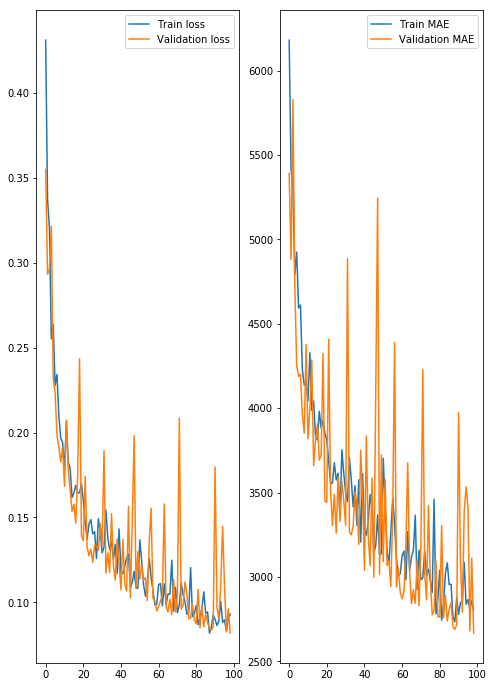

	Train Loss:	0.09318
	Tain MAE:	2805.65095


	Validation Loss:	0.08198
	Validation MAE:	2667.57951


New best model appeared! Loss before: 0.0827, loss aftrer 0.0820
Patience 1


In [38]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100


model = FullNetwork(use_bn=False, use_dropout=False, title_encoder=TitleEncoder(out_size=64, use_bn=False),
                    description_encoder=JobDescriptionEncoder(out_size=64, use_batchnorm=False)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model=model, opt=opt, patience=10, device=device)

In [39]:
visualize_loss(model=model, device=device)

Final eval:



	Loss:	0.08198
	MAE:	2667.57951





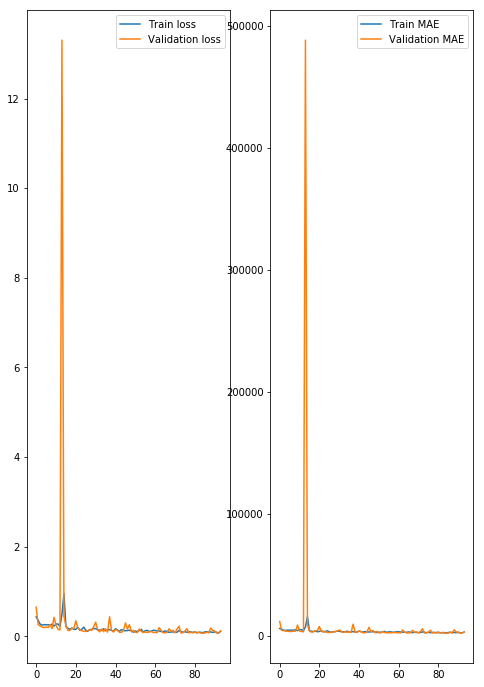

	Train Loss:	0.11341
	Tain MAE:	3454.20380


	Validation Loss:	0.12325
	Validation MAE:	3359.10906


Breakin the loop. Best loss 0.07243423116655132.


In [41]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100


model = FullNetwork(use_bn=False, use_dropout=False, title_encoder=TitleEncoder(out_size=64, use_bn=False),
                    description_encoder=JobDescriptionEncoder(out_size=64, use_batchnorm=False)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
train(model=model, opt=opt, patience=10, device=device)

In [42]:
visualize_loss(model=model, device=device)

Final eval:



	Loss:	0.07243
	MAE:	2535.28809





In [ ]:
# Baseline + batchnorm

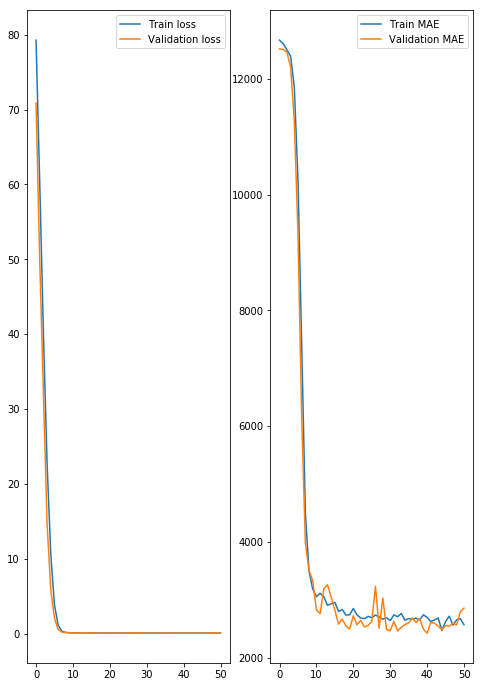

	Train Loss:	0.07233
	Tain MAE:	2568.03013


	Validation Loss:	0.08763
	Validation MAE:	2854.81572


Breakin the loop. Best loss 0.06520259165588548.


In [47]:
num_epochs = 200
max_len = 100
batch_size = 32
batches_per_epoch = 100

model = FullNetwork(use_dropout=False).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model=model, opt=opt, patience=10, device=device)

In [48]:
visualize_loss(model=model, device=device)

Final eval:



	Loss:	0.06520
	MAE:	2422.13454





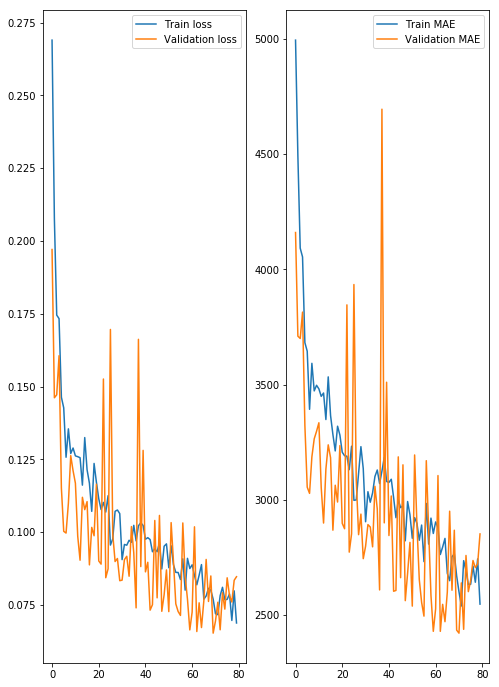

	Train Loss:	0.06883
	Tain MAE:	2547.96006


	Validation Loss:	0.08473
	Validation MAE:	2852.42849


Breakin the loop. Best loss 0.06534241516800487.


In [45]:
num_epochs = 200
max_len = 100
batch_size = 32
batches_per_epoch = 100

model = FullNetwork(use_dropout=False).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
train(model=model, num_epochs=num_epochs, opt=opt, patience=10, device=device)

In [46]:
visualize_loss(model=model, device=device)

Final eval:



	Loss:	0.06534
	MAE:	2435.19256





In [60]:
# Parallel convolutions

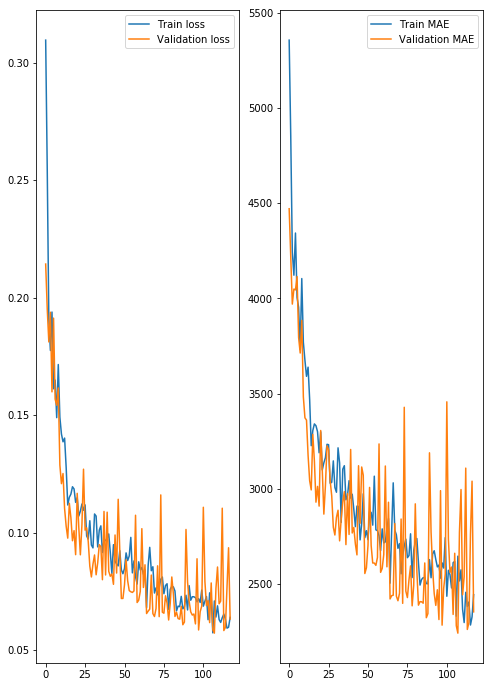

	Train Loss:	0.06394
	Tain MAE:	2444.24755


	Validation Loss:	0.06324
	Validation MAE:	2354.19452


Breakin the loop. Best loss 0.057225135005280085.


In [42]:
num_epochs = 200
max_len = 100
batch_size = 32
batches_per_epoch = 100

model = FullNetwork(description_encoder=JobDescriptionEncoder_cnn_parallel(), use_dropout=False).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
train(model=model, opt=opt, num_epochs=num_epochs, patience=10, device=device)

In [43]:
visualize_loss(model=model, device=device)

Final eval:



	Loss:	0.05723
	MAE:	2242.40504





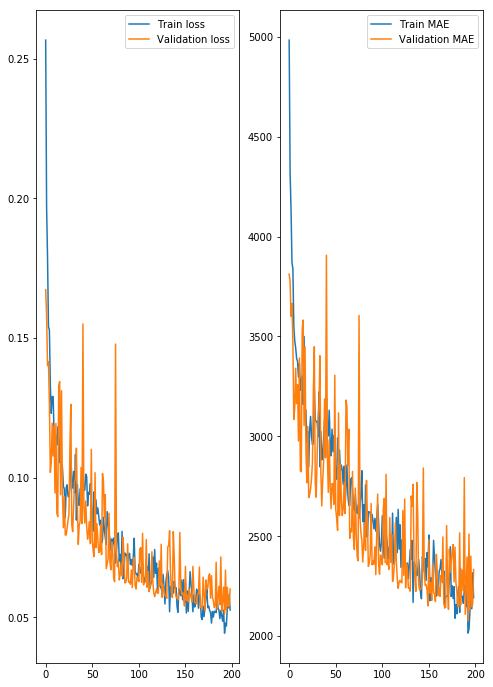

	Train Loss:	0.05261
	Tain MAE:	2193.24792


	Validation Loss:	0.06014
	Validation MAE:	2334.19572


Patience 7


In [43]:
# 2 parallel convolutions merged after GlobalPooling
num_epochs = 200
max_len = 100
batch_size = 32
batches_per_epoch = 100

model = FullNetwork(description_encoder=JobDescriptionEncoder_cnn_parallel2(), use_dropout=False).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
train(model=model, opt=opt, num_epochs=num_epochs, patience=15, device=device)

In [44]:
visualize_loss(model=model, device=device)

Final eval:



	Loss:	0.05107
	MAE:	2076.35943





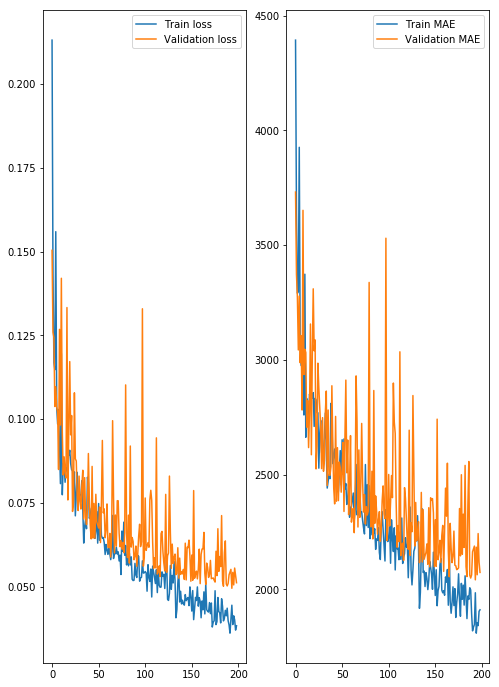

	Train Loss:	0.03829
	Tain MAE:	1910.86423


	Validation Loss:	0.05114
	Validation MAE:	2073.82573


Patience 6


In [55]:
# 2 parallel convolutions merged after GlobalPooling
num_epochs = 200
max_len = 100
batch_size = 32
batches_per_epoch = 100

model = FullNetwork(description_encoder=JobDescriptionEncoder_cnn_parallel4(), use_dropout=False).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
train(model=model, opt=opt, num_epochs=num_epochs, patience=20, device=device)

In [56]:
visualize_loss(model=model, device=device)

Final eval:



	Loss:	0.04948
	MAE:	2041.49769





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

Baseline - MAE 3548, loss 0.11271

Baseline + early stopping - MAE 2768, loss 0.08282 

Baseline + batchnorm, early stopping - MAE , loss 

CNN architecture - 